In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent. 

The  gradient descent rule is, for $l = 1, ..., L$: 
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

where L is the number of layers and $\alpha$ is the learning rate.

In [4]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]
       
        
    return parameters

## 2 - Mini-Batch Gradient descent

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in partitionning
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## 3 - Momentum

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps.

In [5]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # velocity initialization
    for l in range(L):
        
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)

        
    return v

The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate.

In [6]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        
        # compute velocities
        v["dW" + str(l+1)] = beta * v['dW' + str(l+1)] + (1 - beta) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta * v['db' + str(l+1)] + (1 - beta) * grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * v['db' + str(l+1)]
        
    return parameters, v

## 4 - Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero


In [7]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. 
    for l in range(L):
    
        v["dW" + str(l+1)] = np.zeros_like(parameters['W' + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters['b' + str(l+1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters['W' + str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters['b' + str(l+1)])
    
    return v, s

In [8]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Adam update on all parameters
    for l in range(L):
        
        # Moving average of the gradients.
        v["dW" + str(l+1)] = beta1 * v['dW' + str(l+1)] + (1 - beta1) * grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v['db' + str(l+1)] + (1 - beta1) * grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate.
        v_corrected["dW" + str(l+1)] = v['dW' + str(l+1)] / (1 - beta1)
        v_corrected["db" + str(l+1)] = v['db' + str(l+1)] / (1 - beta1)

        # Moving average of the squared gradients.
        s['dW' + str(l+1)] = beta2 * s['dW' + str(l+1)] + (1 - beta2) * (grads["dW" + str(l+1)] * grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2 * s['db' + str(l+1)] + (1 - beta2) * (grads["db" + str(l+1)] * grads["db" + str(l+1)])

        # Compute bias-corrected second raw moment estimate.
        s_corrected["dW" + str(l+1)] = s['dW' + str(l+1)] / (1 - beta2)
        s_corrected["db" + str(l+1)] = s['db' + str(l+1)] / (1 - beta2)

        # Update parameters. 
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v_corrected['dW' + str(l+1)] / (np.sqrt(s_corrected['dW' + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters, v, s

## 5 - Model with different optimization algorithms


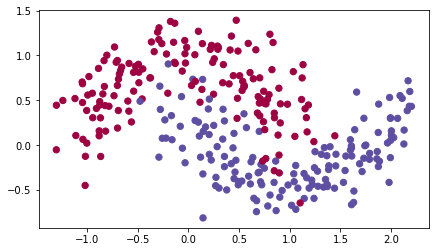

In [9]:
train_X, train_Y = load_dataset()

In [15]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 15000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                       
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### 5.1 - Mini-batch Gradient descent


Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367
Cost after epoch 5000: 0.551977
Cost after epoch 6000: 0.532370
Cost after epoch 7000: 0.514007
Cost after epoch 8000: 0.496472
Cost after epoch 9000: 0.468014
Cost after epoch 10000: 0.433215
Cost after epoch 11000: 0.385622
Cost after epoch 12000: 0.359900
Cost after epoch 13000: 0.346863
Cost after epoch 14000: 0.338159


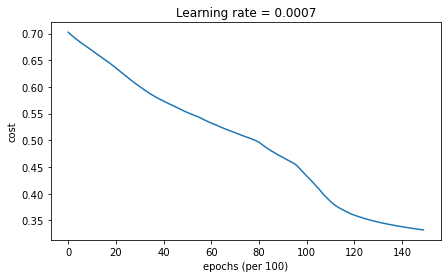

Accuracy: 0.87


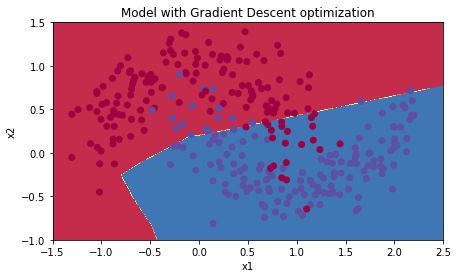

In [16]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.2 - Mini-batch gradient descent with momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444
Cost after epoch 5000: 0.552058
Cost after epoch 6000: 0.532458
Cost after epoch 7000: 0.514101
Cost after epoch 8000: 0.496652
Cost after epoch 9000: 0.468160
Cost after epoch 10000: 0.433586
Cost after epoch 11000: 0.385991
Cost after epoch 12000: 0.360027
Cost after epoch 13000: 0.346938
Cost after epoch 14000: 0.338214


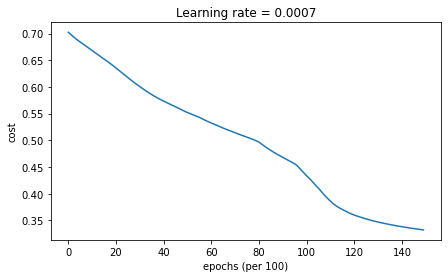

Accuracy: 0.87


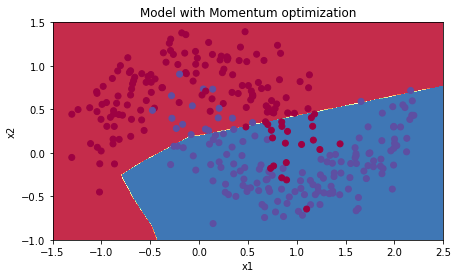

In [17]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.3 - Mini-batch with Adam mode

Cost after epoch 0: 0.702130
Cost after epoch 1000: 0.318100
Cost after epoch 2000: 0.205118
Cost after epoch 3000: 0.160727
Cost after epoch 4000: 0.147537
Cost after epoch 5000: 0.142568
Cost after epoch 6000: 0.140468
Cost after epoch 7000: 0.139397
Cost after epoch 8000: 0.138789
Cost after epoch 9000: 0.137847
Cost after epoch 10000: 0.136780
Cost after epoch 11000: 0.136093
Cost after epoch 12000: 0.135475
Cost after epoch 13000: 0.134859
Cost after epoch 14000: 0.134208


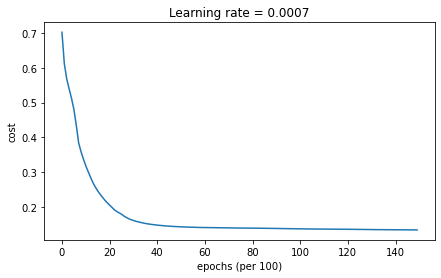

Accuracy: 0.9433333333333334


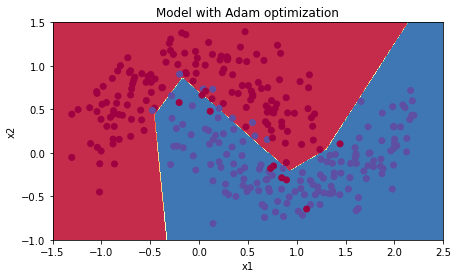

In [18]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)